
# **Object Recognition: BoF vs ConvNets**

The goal of this notebook is to implement two object recognition approaches:

1. A classifier based on the **Bag of Features** method:  
  a) Using **Random Forest** as classifier  
  b) Experimenting with different sizes for the dictionary and detectors  
2. A classifier using **ConvNet** implemented in **Pytorch**:  
  a) Using an architecture inspired by the **LeNet5**

A [discussion](#discussion) considering the obtained results is conducted at the end of the notebook.

## **Environment Preparation**

In [1]:
pip install -U opencv-contrib-python

     |████████████████████████████████| 55.7MB 54kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
import cv2, itertools, sklearn, torch, torchvision, sys

import numpy as np
import scipy.cluster.vq as vq
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

print('OpenCV version:', cv2.__version__)

OpenCV version: 4.4.0


## **BoF Functions**

In [4]:
def feature_sampling(image, detector):
    """Samples keypoints from the input image using the given detector name.

    Args: 
        image: [numpy.ndarray] Image to sample
        detector: [string] Name of the detector to use

    Returns:
        keypoints: [cv.KeyPoint] List of keypoints

    """

    # Select detector
    if(detector.upper() == 'FAST'):
        detector = cv2.FastFeatureDetector_create(30)

    elif(detector.upper() == 'SIFT'):
        if(cv2.__version__ == '4.0.1'):
            detector = cv2.xfeatures2d.SIFT_create()
        
        else:
            detector = cv2.SIFT_create()

    else:
        print('>> [ERROR] Wrong detector name')
        sys.exit()

    # Detect keypoints
    keypoints = detector.detect(image, None)

    return keypoints


def feature_description(image, keypoints, descriptor):
    """Generates descriptors for the image keypoints using the given descriptor name.

    Args: 
        image: [numpy.ndarray] Image to sample
        keypoints: [cv.KeyPoint] List of keypoints
        descriptor: [string] Name of the descriptor to use

    Returns:
        descriptors: [numpy.ndarray] List of descriptors

    """

    # Select descriptor
    if(descriptor.upper() == 'SIFT'):
        if(cv2.__version__ == '4.0.1'):
            descriptor = cv2.xfeatures2d.SIFT_create()
        else:
            descriptor = cv2.SIFT_create()

    else:
        print('>> [ERROR] Wrong descriptor name')
        sys.exit()

    # Compute descriptors
    _, descriptors = descriptor.compute(image, keypoints)

    return descriptors


def feature_extraction(dataset, detector, descriptor):
    """Detects keypoints and extract features from the whole dataset using the given detector and descriptor.

    Args:
        dataset: [(PIL.Image, int)] List of tuples with images and labels
        detector: [string] Name of the detector to use
        descriptor: [string] Name of the descriptor to use

    Returns:
        features: [numpy.ndarray] List of lists of numpy feature arrays
        labels: [int] List of int labels

    """

    features = []
    labels = []

    for image, label in dataset:
        
        # Convert to array
        numpy_image = np.array(image)

        # Get keypoints
        keypoints = feature_sampling(numpy_image, detector)

        if(keypoints):

            # Get descriptors
            descriptors = feature_description(numpy_image, keypoints, descriptor)

            # Build lists
            features.append(descriptors)
            labels.append(label)

    return features, labels


def codebook_formation(features, size_dict):
    """Generates the codebook for the given list of features.

    Args: 
        features: [numpy.ndarray] List of lists of numpy feature arrays
        size_dict: [int] Size of the dictionary

    Returns:
        codebook: [numpy.ndarray] Array containing the centroid for each feature cluster

    """

    stack_features = []

    # Stack all features
    for features in features:
        stack_features.extend(features)

    # Convert to array
    array_features = np.array(stack_features)

    # Run k-means
    codebook, _ = vq.kmeans(array_features, size_dict, 1)
    
    return codebook


def image_representation(features, codebook):
    """Build the visual words histogram for the given list of features.

    Args: 
        features: [numpy.ndarray] List of lists of numpy feature arrays
        codebook: [numpy.ndarray] Array containing the centroid for each feature cluster

    Returns:
        histogram: [numpy.ndarray] Array containing the value of each bin

    """

    # Get bag of visual words
    words, _ = vq.vq(features, codebook)

    # Calculate bins
    bins = np.arange(codebook.shape[0] + 1)

    # Build normalized histogram
    histogram, _ = np.histogram(words, bins, density=True)
    
    return histogram


def get_features(detector, descriptor):
    """Downloads the CIFAR-10 dataset and extracts features 
    using the given detector and descriptor.

    Args: 
        detector: [string] Name of the detector to use
        descriptor: [string] Name of the descriptor to use

    Returns:
        split_train: [([numpy.ndarray], int)] List of tuples with train features and labels
        split_test: [([numpy.ndarray], int)] List of tuples with test features and labels
        classes: [string] List of class names

    """

    print('>>  Extracting features from the CIFAR-10 dataset...')
    print('>>    Parameters:')
    print('>>      - Detector: %s' % detector)
    print('>>      - Descriptor: %s' % descriptor)

    # Grayscale transform
    transform = transforms.Grayscale()

    print('>>    Downloading the CIFAR-10 dataset...')
    dataset_train, dataset_test, dataset_classes = get_dataset(transform)

    print('>>    Extracting features...')
    split_train = feature_extraction(dataset_train, detector, descriptor)
    split_test = feature_extraction(dataset_test, detector, descriptor)

    print('>>  ...done!')

    return split_train, split_test, dataset_classes


def bof_random_forest(train, test, classes, size_dict, title):
    """Trains a random forest classifier for the given features using bag of features,
    prints train/test accuracies and the confusion matrix.

    Args:
        split_train: [([numpy.ndarray], int)] List of tuples with train features and labels
        split_test: [([numpy.ndarray], int)] List of tuples with test features and labels
        size_dict: [int] Size of the dictionary

    """

    print('>>  Building Bag of Features + Random Forest Classifier...')
    print('>>    Parameters:')
    print('>>      - Dictionary size: %s' % size_dict)

    features_train, labels_train = train
    features_test, labels_test = test
    
    print('>>    Building codebook...')
    codebook = codebook_formation(features_train, size_dict)

    print('>>    Generating images representation...')
    bow_train = [image_representation(features, codebook) for features in features_train]
    bow_test = [image_representation(features, codebook) for features in features_test]

    print('>>    Training classifier...')
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(bow_train, labels_train)

    print('>>    Obtaining predictions...')
    predictions_train = classifier.predict(bow_train)
    predictions_test = classifier.predict(bow_test)  

    print('>>    Calculating metrics...')
    accuracy_train = sklearn.metrics.accuracy_score(labels_train, predictions_train)
    accuracy_test = sklearn.metrics.accuracy_score(labels_test, predictions_test)

    print('>>    Final Accuracy:')
    print('>>      - Train: %f' % accuracy_train)
    print('>>      - Test: %f' % accuracy_test)
    
    show_confusion_matrix(predictions_test, labels_test, classes, title)

    print('>>  ...done!')

## **CNN Functions**

In [6]:
def test(model, data_loader):
    """Run the model in test mode on the given data loader.

    Args: 
        model: [torch.nn.Module] Pytorch neural network module
        data_loader: [torch.utils.data.DataLoader] Data loader for the test set

    Returns:
        test_predictions: [int] List of predictions for the test set
        test_labels: [int] List of labels for the test set
    
    """

    test_scores = []
    test_labels = []

    # Check for GPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for data in data_loader:
            
            # Forward
            inputs, labels = data[0].to(device), data[1].to(device)
            scores = model(inputs)
            
            # Save results
            test_scores.extend(scores.tolist())
            test_labels.extend(labels.tolist())

        # Calculate accuracy
        test_predictions = get_predictions(test_scores)

    return test_predictions, test_labels


class MyNet5(nn.Module):
    """Convolutional Neural Network module inspired in the LeNet5."""

    def __init__(self):
        super(MyNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 124)
        self.fc3 = nn.Linear(124, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def convolutional_neural_network(number_epochs, rate_learning, size_batch, optimizer):
    """Trains the CNN, prints train/test accuracies and the confusion matrix at the end of each epoch.

    Args:
        number_epochs: [int] Number of epochs to train
        rate_learning: [float] Learning rate to use
        size_batch: [int] Sizer of the batch
        optimizer: [string] Name of the optimizer to use

    """

    # Normalization transform
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    print('>>    Downloading the CIFAR-10 dataset...')
    dataset_train, dataset_test, dataset_classes = get_dataset(transform)

    print('>>    Building data loaders...')
    train_loader, test_loader = get_dataloader(dataset_train, dataset_test, size_batch)

    print('>>  Building Convolutional Neural Network...')
    print('>>    Parameters:')
    print('>>      - Number of Epochs: %d' % number_epochs)
    print('>>      - Learning Rate: %f' % rate_learning)
    print('>>      - Batch size: %d' % size_batch)

    # Check for GPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Build CNN and move to GPU
    model = MyNet5()
    model.to(device)

    # Set loss
    criterion = nn.CrossEntropyLoss()

    # Get optimizer
    if(optimizer.upper() == 'SGD'):
        optimizer = optim.SGD(model.parameters(), lr=rate_learning, momentum=0.9)

    elif(optimizer.upper() == 'ADAM'):
        optimizer =  torch.optim.Adam(model.parameters(), lr=rate_learning, weight_decay=0.0001, amsgrad=True)
       
    else:
        print('>> [ERROR] Wrong optimizer name')
        sys.exit()

    # Print frequency
    print_freq = int(len(train_loader) * 0.2)

    print('>>    Training CNN...')

    # Training loop
    for epoch in range(number_epochs):
        
        # Reset lists
        train_scores = []
        train_labels = []
        train_losses = []
        train_accuracy = 0
        
        for counter, data in enumerate(train_loader, 1):

            # Get data and set to GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Reset gradients
            optimizer.zero_grad()

            # Forward
            scores = model(inputs)

            # Calculate loss
            loss = criterion(scores, labels)

            # Backward
            loss.backward()

            # Optimize
            optimizer.step()

            # Save results
            train_scores.extend(scores.tolist())
            train_labels.extend(labels.tolist())
            train_losses.append(loss.item())

            # Print every 20%
            if((counter % print_freq) == 0):

                predictions_train = get_predictions(train_scores)
                train_accuracy = sklearn.metrics.accuracy_score(train_labels, predictions_train)

                # Calculate train accuracy
                print('>>      [Epoch:%d|Step:%d] Acc: %f Loss: %f' %
                    (epoch + 1, counter * size_batch, train_accuracy, np.mean(train_losses)))

        # Calculate test accuracy
        test_predictions, test_labels = test(model, test_loader)
        test_accuracy = sklearn.metrics.accuracy_score(test_labels, test_predictions)

        print('>>      Final Accuracy:')
        print('>>        - Train: %f' % train_accuracy)
        print('>>        - Test: %f' % test_accuracy)

        title = 'Epoch: ' + str(epoch + 1)
        show_confusion_matrix(test_predictions, test_labels, dataset_classes, title)

    print('>>    ...done!')

## **Auxiliary Functions**

In [7]:
def get_dataset(transform):
    """Downloads the torchvision CIFAR-10 dataset applying the given transform.

    Args: 
        transform: [torchvision.transforms] Transform to apply on the dataset images

    Returns:
        train: [(PIL.Image, int)] List of tuples with train images and labels
        test: [(PIL.Image, int)] List of tuples with test images and labels
        classes: [string] List of class names

    """

    print('>>     ', end=' ')
    train = torchvision.datasets.CIFAR10(
                                            root='./data', 
                                            train=True,
                                            download=True, 
                                            transform=transform
                                        )

    print('>>     ', end=' ')
    test = torchvision.datasets.CIFAR10(    root='./data', 
                                            train=False,
                                            download=True, 
                                            transform=transform
                                        )

    classes = (
                    'plane', 'car', 
                    'bird', 'cat',
                    'deer', 'dog', 
                    'frog', 'horse', 
                    'ship', 'truck'
                )

    return train, test, classes


def get_dataloader(train, test, size_batch):
    """Build dataloaders for the train and test sets with the given batch size.

    Args: 
        train: [(PIL.Image, int)] List of tuples with train images and labels
        test: [(PIL.Image, int)] List of tuples with test images and labels

    Returns:
        train_loader: [torch.utils.data.DataLoader] Data loader for the train set
        test_loader: [torch.utils.data.DataLoader] Data loader for the test set

    """

    train_loader = torch.utils.data.DataLoader( 
                                                    train, 
                                                    batch_size=size_batch,
                                                    shuffle=True, 
                                                    num_workers=4
                                                )


    test_loader = torch.utils.data.DataLoader(
                                                    test, 
                                                    batch_size=size_batch,
                                                    shuffle=False, 
                                                    num_workers=4
                                                )

    return train_loader, test_loader


def get_predictions(scores):
    """Gets the predictions from a list fo class scores.

    Args: 
        scores: [numpy.ndarray] List of class scores

    Returns:
        predictions: [int] List of predictions
    
    """

    prediction_scores = np.nan_to_num(scores)
    predictions = np.argmax(prediction_scores, axis=1)

    return predictions


def show_confusion_matrix(predictions, labels, classes, title):
    """Shows the confusion matrix generated from the given predictions and targets.

    Args: 
        predictions: [int] List of predictions
        labels: [int] List of labels
        classes: [string] List of class names
        title: [string] String for picture title

    """

    # Build confusion matrix
    matrix = confusion_matrix(labels, predictions, normalize='true')
    matrix = np.around(matrix, decimals=2)

    # Figure configurations
    figure = plt.figure()
    figure.set_size_inches(14, 10)

    # Plot configurations
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=20, weight='bold')
    plt.colorbar()

    # Set tick labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Color threshold
    threshold = matrix.max() / 2.

    # Add values and colors
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(
                    j, i, matrix[i, j],
                    horizontalalignment="center",
                    color="white" if matrix[i, j] > threshold else "black"
                )

    # Add axes names
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Show matrix
    plt.show()

## **Test Pipeline: BoF + Random Forest Classifier**

>>  Extracting features from the CIFAR-10 dataset...
>>    Parameters:
>>      - Detector: FAST
>>      - Descriptor: SIFT
>>    Downloading the CIFAR-10 dataset...
>>      Files already downloaded and verified
>>      Files already downloaded and verified
>>    Extracting features...
>>  ...done!
>>  Building Bag of Features + Random Forest Classifier...
>>    Parameters:
>>      - Dictionary size: 10
>>    Building codebook...
>>    Generating images representation...
>>    Training classifier...
>>    Obtaining predictions...
>>    Calculating metrics...
>>    Final Accuracy:
>>      - Train: 0.869096
>>      - Test: 0.220755


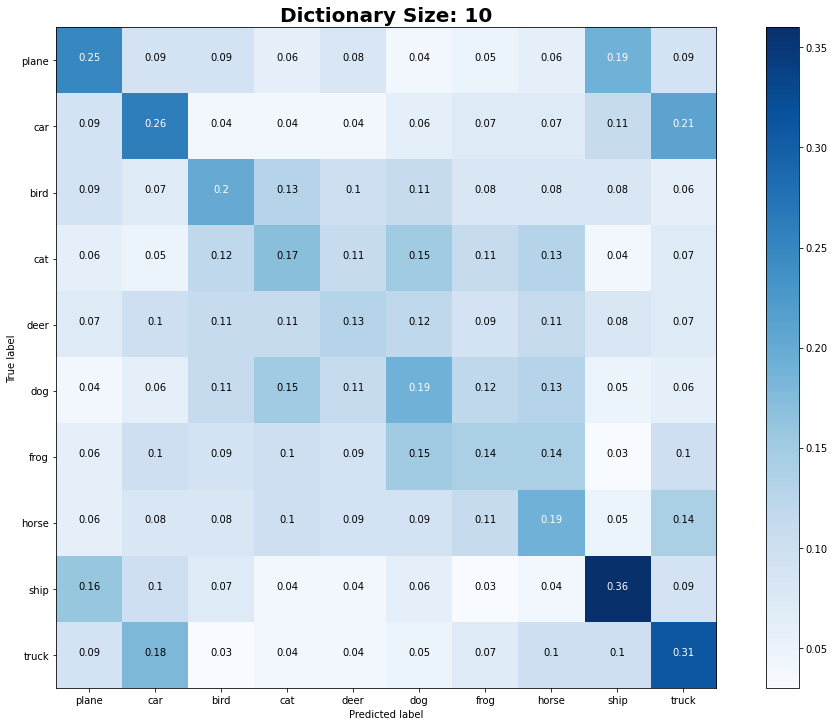

>>  ...done!
>>  Building Bag of Features + Random Forest Classifier...
>>    Parameters:
>>      - Dictionary size: 50
>>    Building codebook...
>>    Generating images representation...
>>    Training classifier...
>>    Obtaining predictions...
>>    Calculating metrics...
>>    Final Accuracy:
>>      - Train: 0.994977
>>      - Test: 0.342440


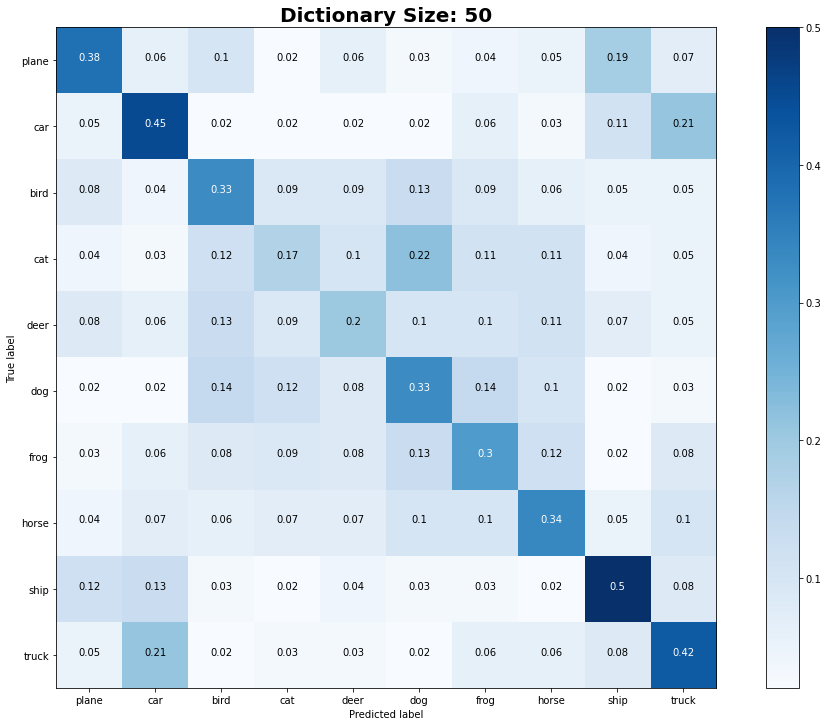

>>  ...done!
>>  Building Bag of Features + Random Forest Classifier...
>>    Parameters:
>>      - Dictionary size: 100
>>    Building codebook...
>>    Generating images representation...
>>    Training classifier...
>>    Obtaining predictions...
>>    Calculating metrics...
>>    Final Accuracy:
>>      - Train: 0.998299
>>      - Test: 0.361053


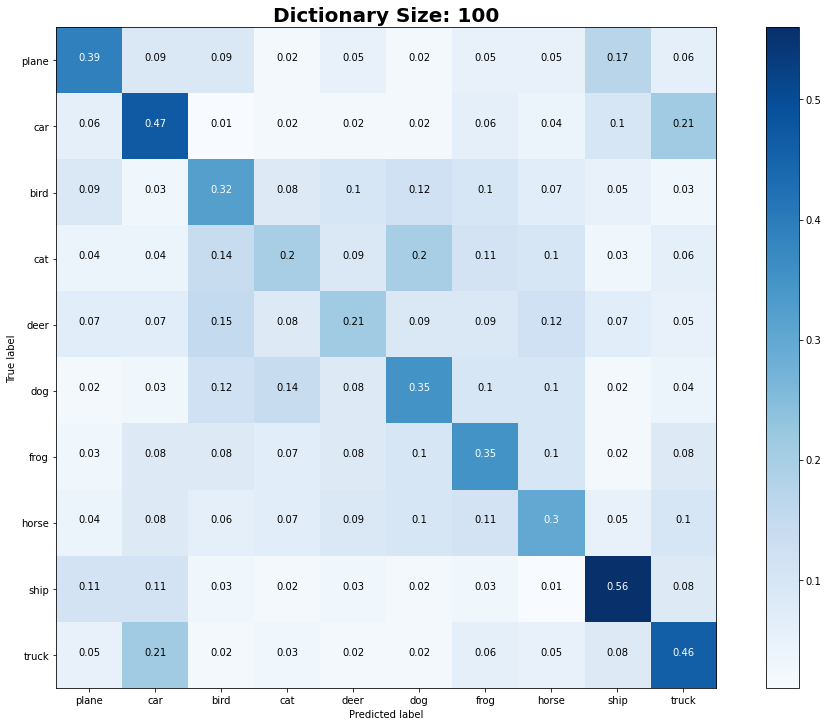

>>  ...done!
>>  Building Bag of Features + Random Forest Classifier...
>>    Parameters:
>>      - Dictionary size: 200
>>    Building codebook...
>>    Generating images representation...
>>    Training classifier...
>>    Obtaining predictions...
>>    Calculating metrics...
>>    Final Accuracy:
>>      - Train: 0.999119
>>      - Test: 0.374762


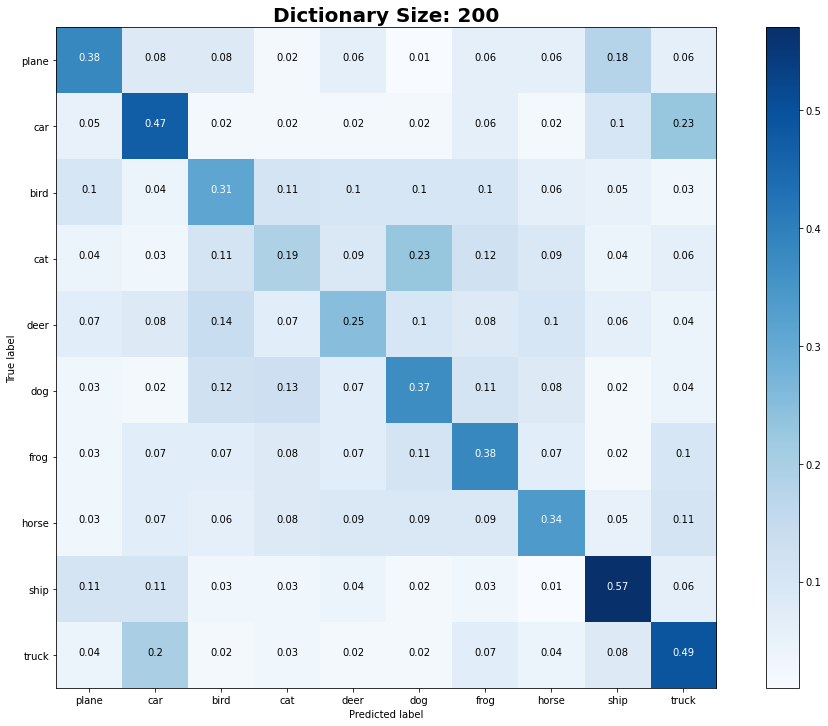

>>  ...done!
>>  Building Bag of Features + Random Forest Classifier...
>>    Parameters:
>>      - Dictionary size: 500
>>    Building codebook...
>>    Generating images representation...
>>    Training classifier...
>>    Obtaining predictions...
>>    Calculating metrics...
>>    Final Accuracy:
>>      - Train: 0.999660
>>      - Test: 0.396478


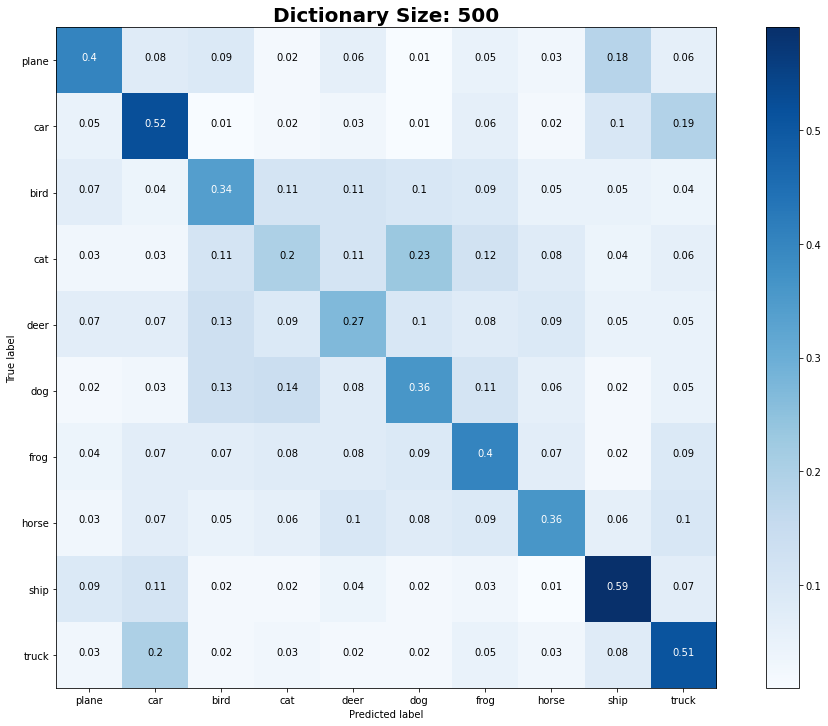

>>  ...done!
>>  Building Bag of Features + Random Forest Classifier...
>>    Parameters:
>>      - Dictionary size: 800
>>    Building codebook...
>>    Generating images representation...
>>    Training classifier...
>>    Obtaining predictions...
>>    Calculating metrics...
>>    Final Accuracy:
>>      - Train: 0.999740
>>      - Test: 0.411088


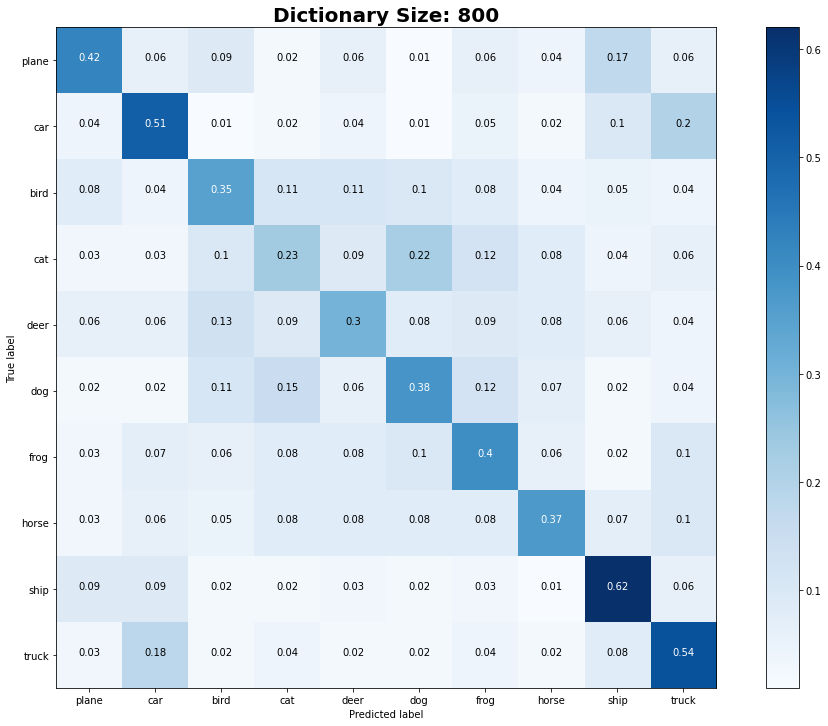

>>  ...done!


In [12]:
# Parameters
detector = 'FAST'
descriptor = 'SIFT'
dictionary_sizes = [10, 50, 100, 200, 500, 800]

# Get features
train, test, classes = get_features(detector, descriptor)

# Train for different dictionary sizes
for size in dictionary_sizes:

    title = 'Dictionary Size: ' + str(size)
    bof_random_forest(train, test, classes, size, title)

## **Test Pipeline: CNN**

>>    Downloading the CIFAR-10 dataset...
>>      Files already downloaded and verified
>>      Files already downloaded and verified
>>    Building data loaders...
>>  Building Convolutional Neural Network...
>>    Parameters:
>>      - Number of Epochs: 10
>>      - Learning Rate: 0.001000
>>      - Batch size: 10
>>    Training CNN...
>>      [Epoch:1|Step:10000] Acc: 0.369200 Loss: 1.701372
>>      [Epoch:1|Step:20000] Acc: 0.427150 Loss: 1.552115
>>      [Epoch:1|Step:30000] Acc: 0.461300 Loss: 1.468911
>>      [Epoch:1|Step:40000] Acc: 0.485650 Loss: 1.405421
>>      [Epoch:1|Step:50000] Acc: 0.504680 Loss: 1.356815
>>      Final Accuracy:
>>        - Train: 0.504680
>>        - Test: 0.607000


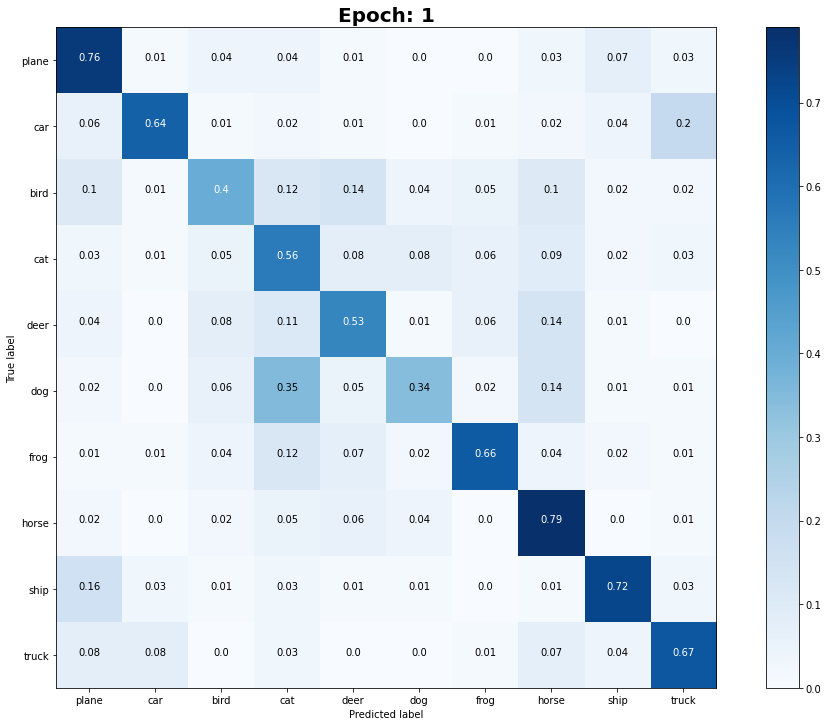

>>      [Epoch:2|Step:10000] Acc: 0.628400 Loss: 1.036807
>>      [Epoch:2|Step:20000] Acc: 0.636100 Loss: 1.023154
>>      [Epoch:2|Step:30000] Acc: 0.639000 Loss: 1.020193
>>      [Epoch:2|Step:40000] Acc: 0.641425 Loss: 1.013564
>>      [Epoch:2|Step:50000] Acc: 0.645300 Loss: 1.002254
>>      Final Accuracy:
>>        - Train: 0.645300
>>        - Test: 0.653500


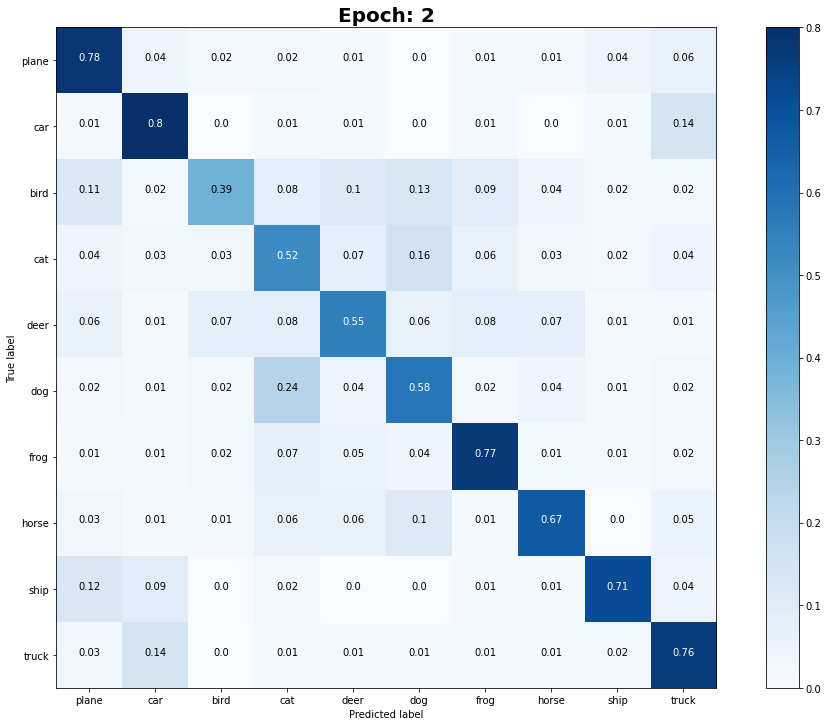

>>      [Epoch:3|Step:10000] Acc: 0.712600 Loss: 0.817981
>>      [Epoch:3|Step:20000] Acc: 0.705800 Loss: 0.835607
>>      [Epoch:3|Step:30000] Acc: 0.703933 Loss: 0.837751
>>      [Epoch:3|Step:40000] Acc: 0.705150 Loss: 0.836412
>>      [Epoch:3|Step:50000] Acc: 0.705960 Loss: 0.835603
>>      Final Accuracy:
>>        - Train: 0.705960
>>        - Test: 0.673900


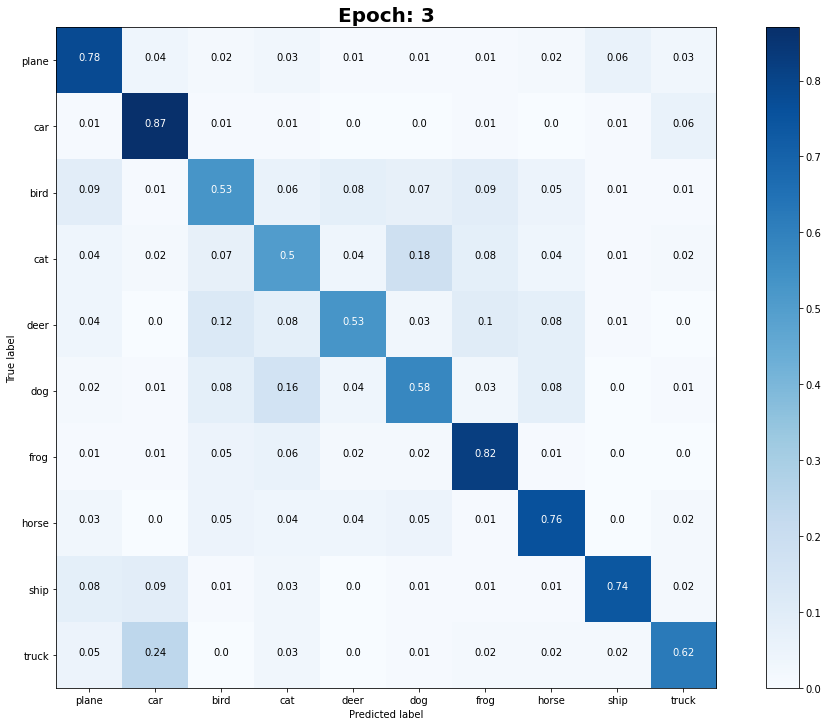

>>      [Epoch:4|Step:10000] Acc: 0.760900 Loss: 0.680666
>>      [Epoch:4|Step:20000] Acc: 0.756350 Loss: 0.695438
>>      [Epoch:4|Step:30000] Acc: 0.754867 Loss: 0.698670
>>      [Epoch:4|Step:40000] Acc: 0.752375 Loss: 0.706562
>>      [Epoch:4|Step:50000] Acc: 0.750580 Loss: 0.710188
>>      Final Accuracy:
>>        - Train: 0.750580
>>        - Test: 0.690000


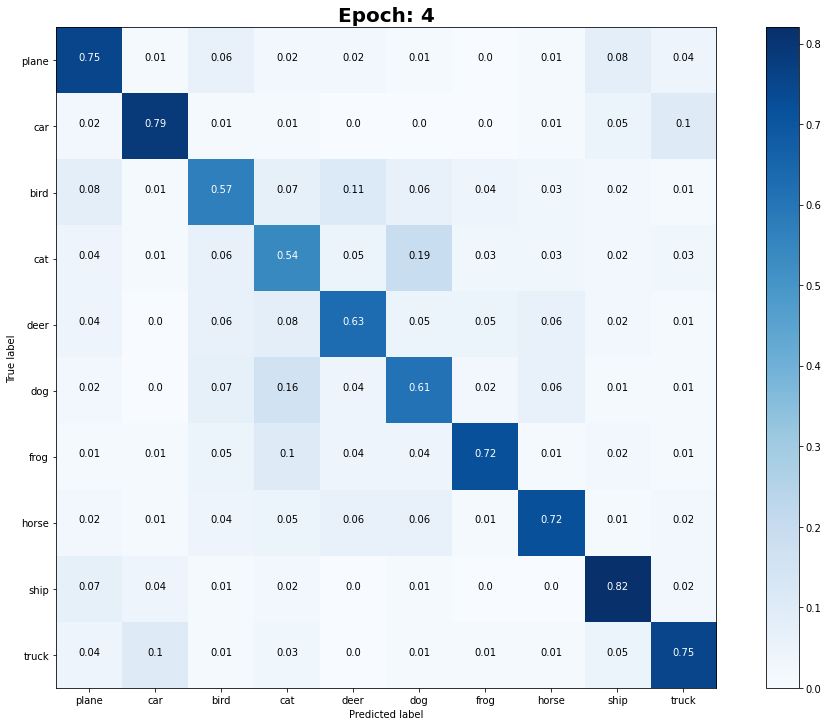

>>      [Epoch:5|Step:10000] Acc: 0.802200 Loss: 0.561854
>>      [Epoch:5|Step:20000] Acc: 0.797750 Loss: 0.571825
>>      [Epoch:5|Step:30000] Acc: 0.794300 Loss: 0.579572
>>      [Epoch:5|Step:40000] Acc: 0.791450 Loss: 0.588149
>>      [Epoch:5|Step:50000] Acc: 0.787320 Loss: 0.598606
>>      Final Accuracy:
>>        - Train: 0.787320
>>        - Test: 0.687700


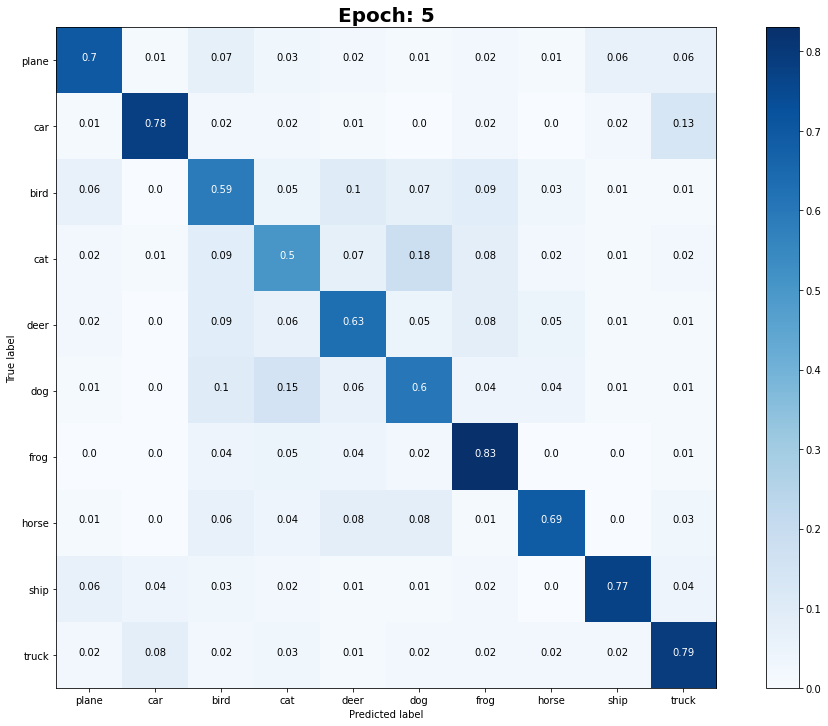

>>      [Epoch:6|Step:10000] Acc: 0.848500 Loss: 0.426728
>>      [Epoch:6|Step:20000] Acc: 0.840000 Loss: 0.454346
>>      [Epoch:6|Step:30000] Acc: 0.833700 Loss: 0.469376
>>      [Epoch:6|Step:40000] Acc: 0.827750 Loss: 0.483724
>>      [Epoch:6|Step:50000] Acc: 0.824540 Loss: 0.492485
>>      Final Accuracy:
>>        - Train: 0.824540
>>        - Test: 0.684000


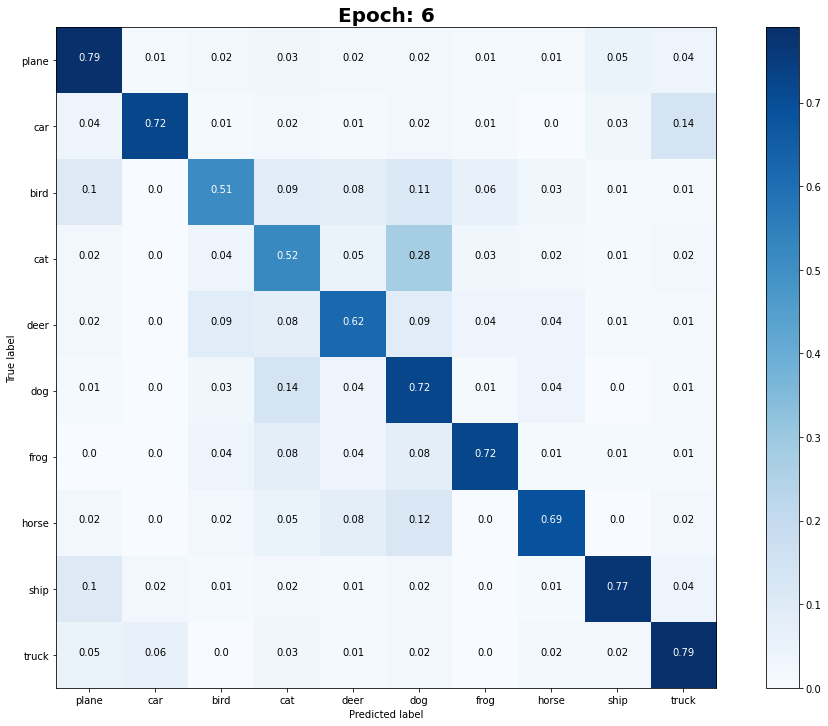

>>      [Epoch:7|Step:10000] Acc: 0.889800 Loss: 0.323327
>>      [Epoch:7|Step:20000] Acc: 0.876450 Loss: 0.355452
>>      [Epoch:7|Step:30000] Acc: 0.865500 Loss: 0.382370
>>      [Epoch:7|Step:40000] Acc: 0.859125 Loss: 0.399046
>>      [Epoch:7|Step:50000] Acc: 0.853820 Loss: 0.413839
>>      Final Accuracy:
>>        - Train: 0.853820
>>        - Test: 0.680000


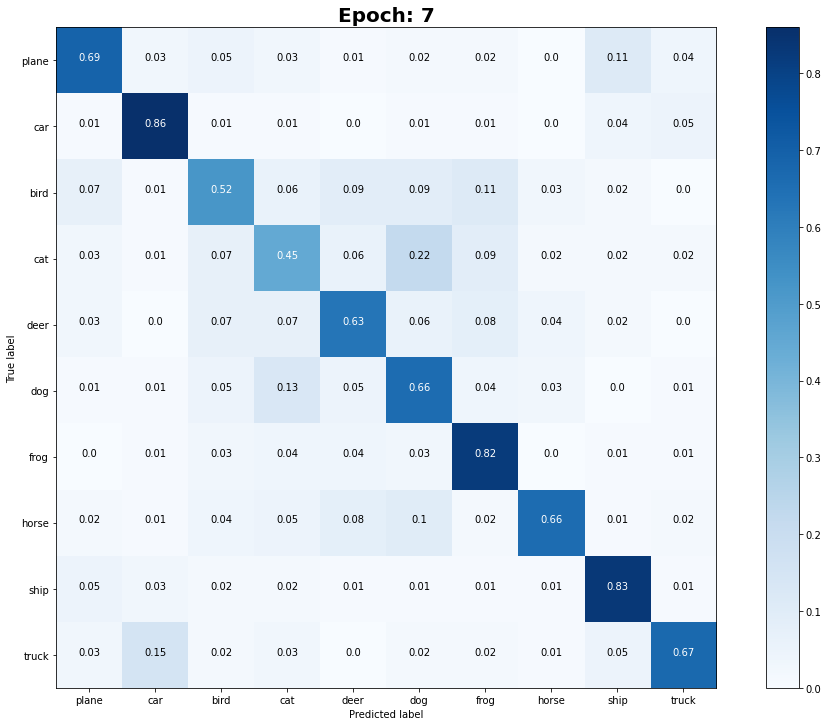

>>      [Epoch:8|Step:10000] Acc: 0.909400 Loss: 0.267667
>>      [Epoch:8|Step:20000] Acc: 0.900750 Loss: 0.289768
>>      [Epoch:8|Step:30000] Acc: 0.895033 Loss: 0.304663
>>      [Epoch:8|Step:40000] Acc: 0.888700 Loss: 0.320723
>>      [Epoch:8|Step:50000] Acc: 0.884660 Loss: 0.330531
>>      Final Accuracy:
>>        - Train: 0.884660
>>        - Test: 0.680200


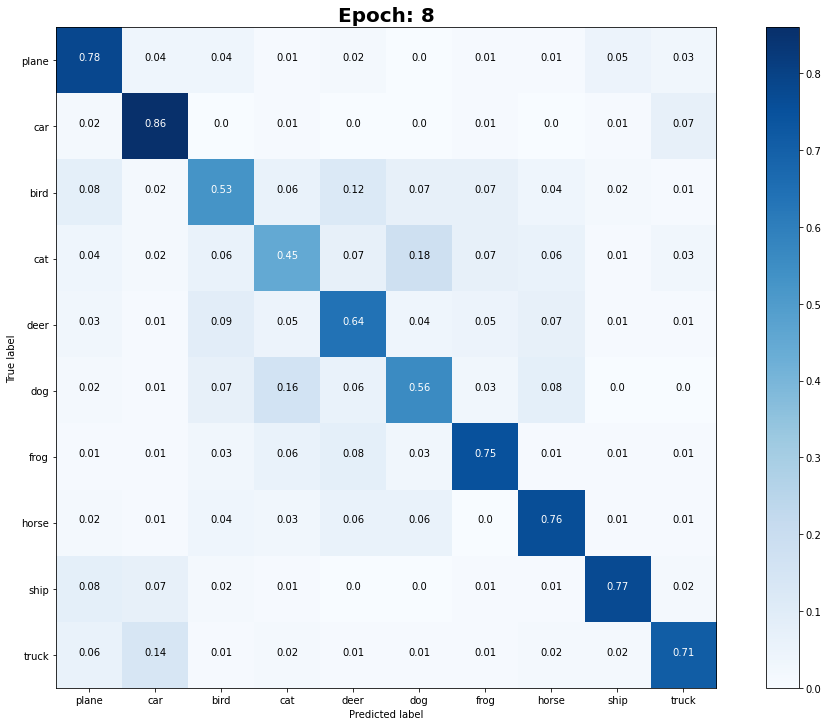

>>      [Epoch:9|Step:10000] Acc: 0.932000 Loss: 0.201906
>>      [Epoch:9|Step:20000] Acc: 0.920250 Loss: 0.228437
>>      [Epoch:9|Step:30000] Acc: 0.915533 Loss: 0.242338
>>      [Epoch:9|Step:40000] Acc: 0.910575 Loss: 0.257030
>>      [Epoch:9|Step:50000] Acc: 0.904640 Loss: 0.272236
>>      Final Accuracy:
>>        - Train: 0.904640
>>        - Test: 0.677200


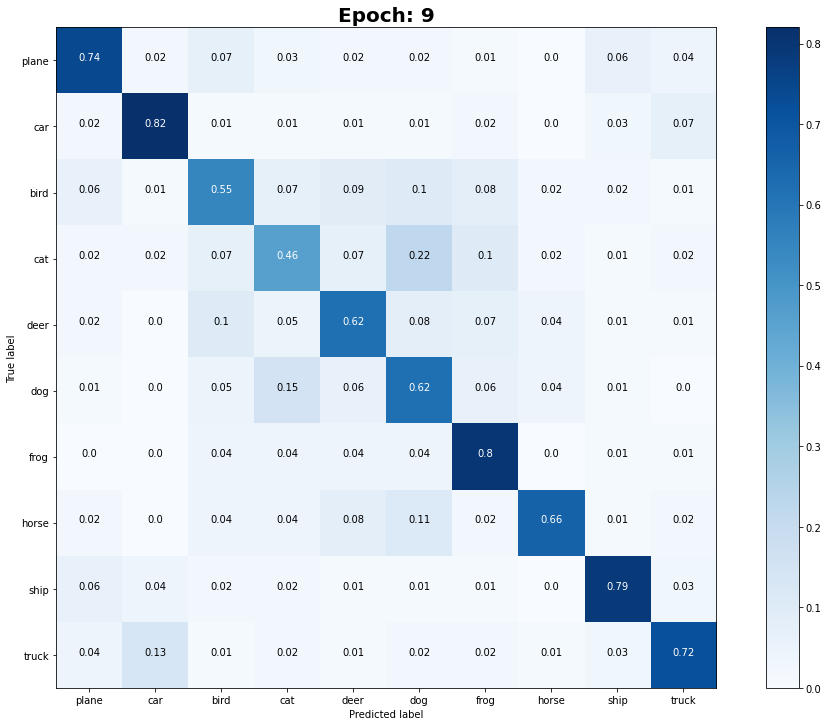

>>      [Epoch:10|Step:10000] Acc: 0.944300 Loss: 0.164722
>>      [Epoch:10|Step:20000] Acc: 0.936550 Loss: 0.182893
>>      [Epoch:10|Step:30000] Acc: 0.930267 Loss: 0.200572
>>      [Epoch:10|Step:40000] Acc: 0.923925 Loss: 0.215022
>>      [Epoch:10|Step:50000] Acc: 0.919440 Loss: 0.227519
>>      Final Accuracy:
>>        - Train: 0.919440
>>        - Test: 0.670100


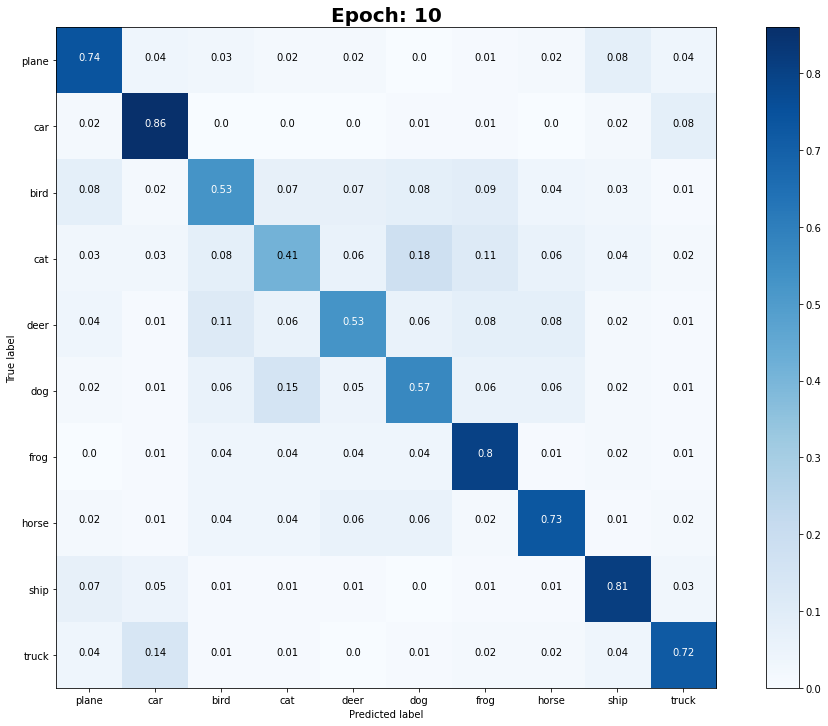

>>    ...done!


In [10]:
# Parameters
number_epochs = 10
rate_learning = 0.001
size_batch = 10
optimizer = 'ADAM'

# Train
convolutional_neural_network(number_epochs, rate_learning, size_batch, optimizer)

# **Report**

##**Results: Best Accuracy**

**BoF and Random Forest:**

* SIFT - Dictionary Size: 800
  * Train: 99.93%
  * Test: 26.95%

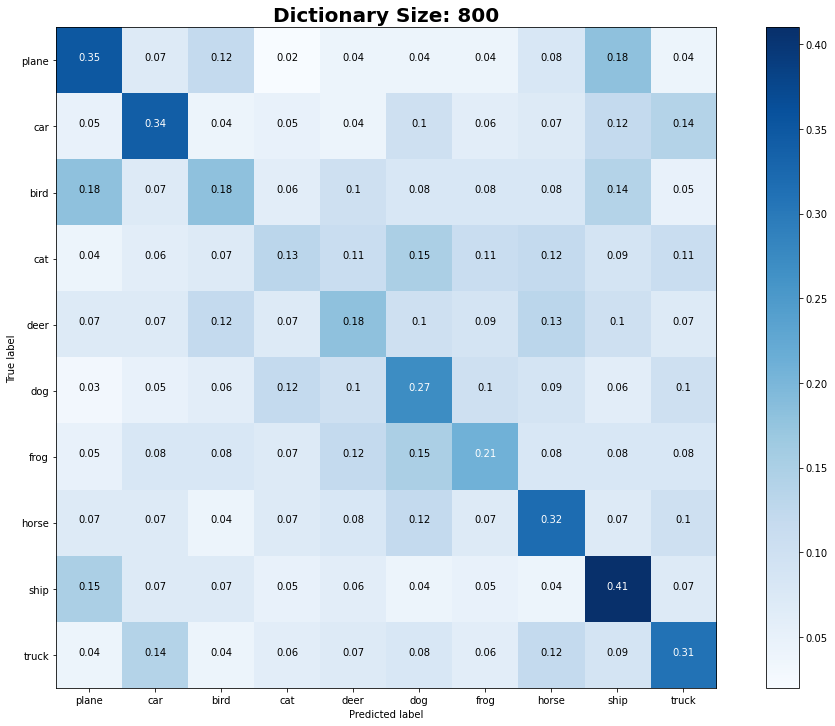

* FAST - Dictionary Size: 800
  * Train: 99.97%
  * Test: 41.10%

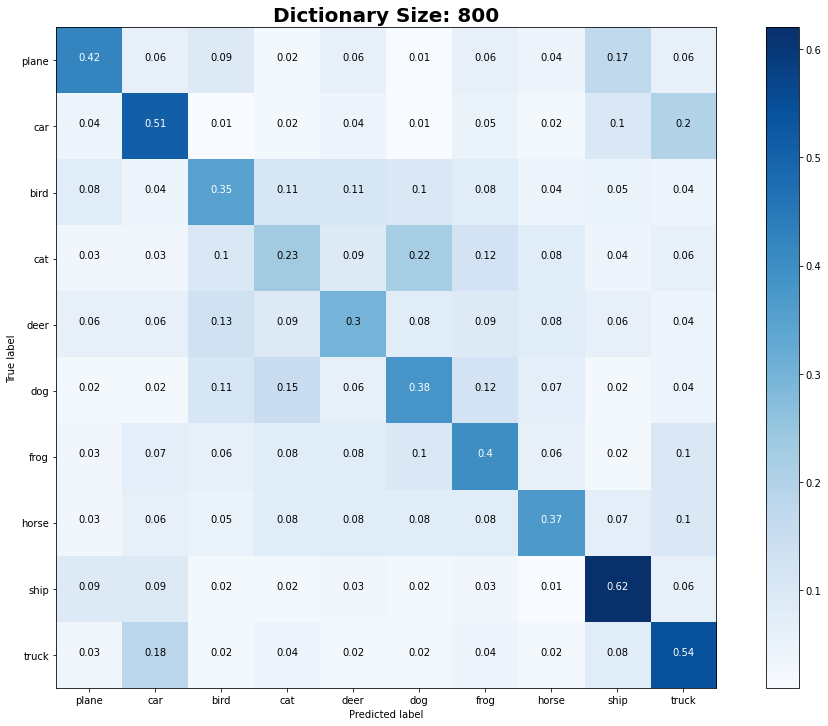

**ConvNet:**

* Epoch: 4
  * Train: 75.05%
  * Test: 69.00%

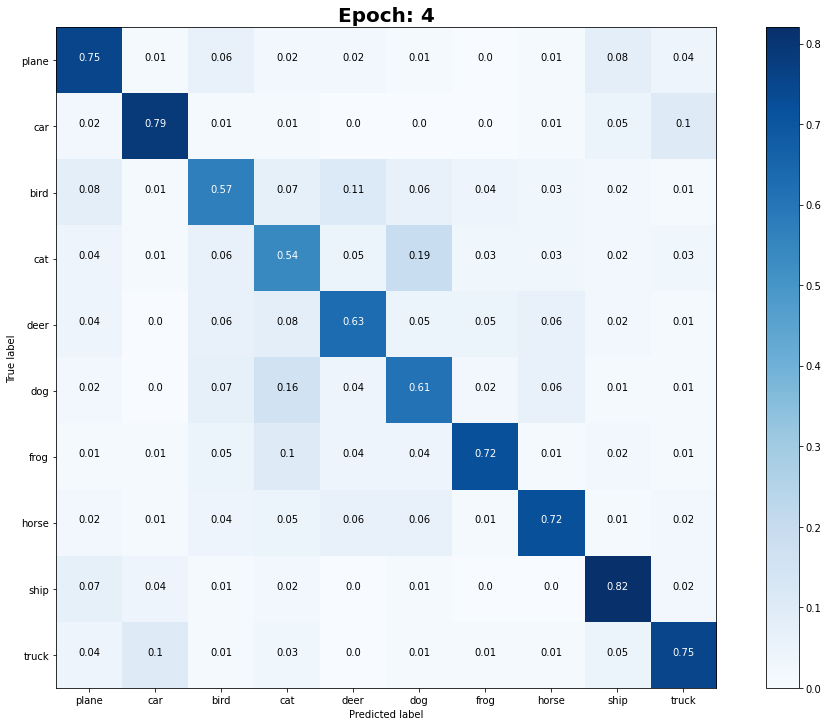

## **Discussion:**

For the BoF approach, a dictionary size of 50 is enough to achieve around 99,5% accuracy on the train data, but the model still generalizes poorly for the test set, where it only gets 34.24% accuracy. Further increases of the dictionary size helps to improve the generalization to 41.1% with size 800, but the gains are still too low, making it not worth the computational cost. So, according to the Ockham's razor principle, a dictionary size around 50 would be the most adequate to describe the data.

Two types of detectors were tested, with FAST performing much better than SIFT, which reached a maximum of only 26.95% accuracy. This may happen because SIFT detects a lower amount of keypoints and not even being able to find any for some images, showing how dependent on the sampling technique the BoF is. However, the FAST detector generates a lot of redundant keypoints, taking much more time to run (about 1 hour for the whole test pipeline).

On the other hand, the ConvNet performed much better, even with a lower initial accuracy of 50.46% after the first epoch on the train set, the test accuracy was 60.70%. The highest test accuracy was 69% obtained after epoch 4, from this point the network started to overfit, with test accuracy slowly degrading with each epoch. This shows that the most important part of a model is its capacity of generalizing the learned features to be capable of correctly classify unseen samples.

The confusion matrices shows that both models had trouble classifying images with more similar features, such as cars and trucks, cats and dogs, and also birds and planes.